# Exercise 10: Image stitching

## Helper functions

In [23]:
import numpy as np
import cv2 
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib
import skimage

def load_im(path : str) -> np.ndarray:
    """
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    return im


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom


def hest(q1, q2) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x)) # <-- formula follows that of week 2, slide 56
        # print(np.kron(q2t_hom.T, q1x).shape)
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    
def crossOp(p : np.ndarray) -> np.ndarray:
    """
        One of Them weird functions. It takes in a 3D vector and then returns
        some gnarly matrix.
    """
    p = p.flatten()
    if p.size != 3:
        raise Exception("Invalid input, vector must be exactly 3D.")
    
    x, y, z = p
    px = np.array(
        [[0, -z, y],
         [z, 0, -x],
         [-y, x, 0]]
    )
    
    return px


def computeFundamentalMatrix(K1 : np.ndarray, K2 : np.ndarray, R2 : np.ndarray, t2 : np.ndarray) -> np.ndarray:
    """
        Computing the fundamental matrix between two camera matrices K1 & K2.
    """
    t2x = crossOp(t2)

    E = t2x @ R2

    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)

    F = K1inv.T @ E @ K2inv
    
    return F


def fancyRotate(theta_x, theta_y, theta_z):
    """
        Does the rotation matrix that we have seen a few times.
        E.g. Exercises week 4, eq(12).
    """
    from scipy.spatial.transform import Rotation
    
    R = Rotation.from_euler("xyz", [theta_x, theta_y, theta_z]).as_matrix()
    
    return R


def in_frame(l, l_im, shape):
    """
        I think this checks whether the line is within the image
    """
    q = np.cross(l.flatten(), l_im)
    q = q[:2]/q[2]
    if all(q >= 0) and all(q+1 <= shape[1::-1]):
        return q
  
    
def DrawLine(l, shape):
    """
        Checks where the line intersects the four sides of the image
        and finds the two intersections that are within the frame
    """
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l, l_im, shape) for l_im in lines if in_frame(l, l_im, shape) is not None]
    plt.plot(*np.array(P).T)


def draw_line_Vitus(line: np.ndarray, tau: float):
    """
        Draws a line with a width of tau.
        
        Takes:
            :param line: The line to be drawn
            :param tau: The distance from the line to be drawn
        
        Returns:
            :return: None
    """
    
    x1, x2 = plt.gca().get_xlim()
    y1 = -(line[0]*x1 + line[2]) / line[1]
    y2 = -(line[0]*x2 + line[2]) / line[1]
    y1_low = -(line[0]*x1 + line[2] + tau) / line[1]
    y1_high = -(line[0]*x1 + line[2] - tau) / line[1]
    y2_low = -(line[0]*x2 + line[2] + tau) / line[1]
    y2_high = -(line[0]*x2 + line[2] - tau) / line[1]
    
    plt.axline((x1,y1), (x2,y2), c='black')
    plt.axline((x1,y1_low), (x2,y2_low), c='black', linestyle='dashed')
    plt.axline((x1,y1_high), (x2,y2_high), c='black', linestyle='dashed')
    



## Ex. 11.1 

Find SIFT keypoints (`kp0`, `kp1`, `kp2`) in all three images and compute their corresponding descriptors (`des0`, `des1`, `des2`). For speed reasons, you can limit the number of **SIFT** features to 2000. Convert the features to numpy arrays of 2D points

`kp = np.array([k.pt for k in kp])`


Match the SIFT features between im0 and im1 (matches01), and between im1 and im2 (matches12). Convert the matches to numpy arrays of the indices

`matches = np.array([(m.queryIdx, m.trainIdx) for m in matches])`.


### Response

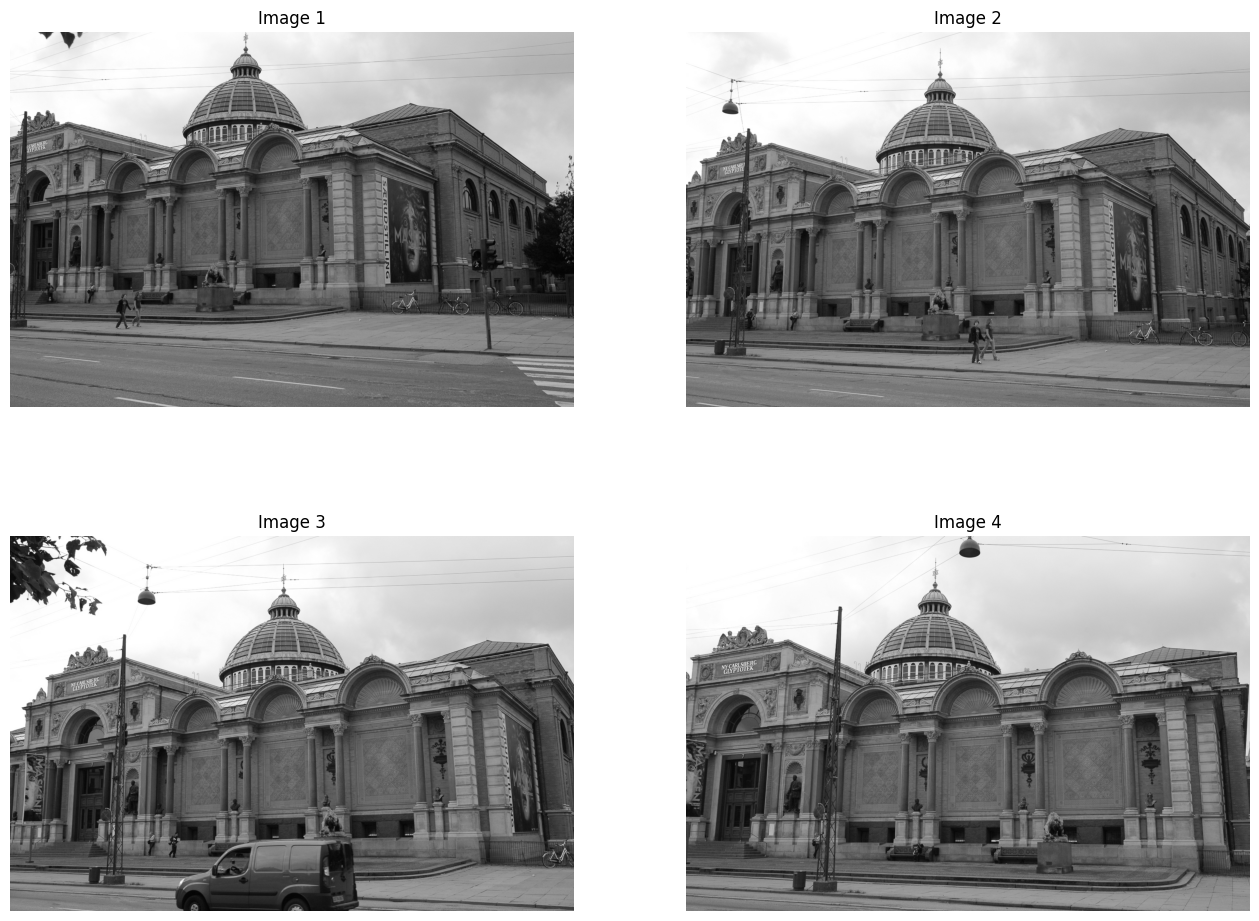

In [24]:
PATH = "../Data/Week_11/"

K = np.loadtxt(PATH + "K.txt")

# Loading in images as numpy arrays
im1 = load_im(PATH + "sequence/000001.png")
im2 = load_im(PATH + "sequence/000002.png")
im3 = load_im(PATH + "sequence/000003.png")
im4 = load_im(PATH + "sequence/000004.png")

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.title("Image 1")
plt.axis("off")
plt.imshow(im1)

plt.subplot(2, 2, 2)
plt.title("Image 2")
plt.axis("off")
plt.imshow(im2)

plt.subplot(2, 2, 3)
plt.title("Image 3")
plt.axis("off")
plt.imshow(im3)

plt.subplot(2, 2, 4)
plt.title("Image 4")
plt.axis("off")
plt.imshow(im4)

plt.show()


#### Actually doing the exercise

In [25]:
# Loading in images as cv2
im1_cv = cv2.imread(PATH + "sequence/000001.png")
im2_cv = cv2.imread(PATH + "sequence/000002.png")
im3_cv = cv2.imread(PATH + "sequence/000003.png")

# Initiate SIFT detector
sift = cv2.SIFT_create(2000) # <--- parsing a number here means it will only find that many SIFT features.

# NOTE: It is necessary to load images with cv2 if you intend to find SIFT features!
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1_cv, None)
kp2, des2 = sift.detectAndCompute(im2_cv, None)
kp3, des3 = sift.detectAndCompute(im3_cv, None)

# Converting the features to numpy arrays (of 2D points)
kp1_np = np.array([k.pt for k in kp1])
kp2_np = np.array([k.pt for k in kp2])
kp3_np = np.array([k.pt for k in kp3])

# BFMatcher with default params
bf = cv2.BFMatcher_create(crossCheck = True)

# Matching the features between im1 and im2
matches12 = bf.match(des1, des2)    # <-- For some reason we aren't using KNN here

# Matching the features between im2 and im3
matches23 = bf.match(des2, des3)    # <-- For some reason we aren't using KNN here

# Converting the matches to numpy arrays
matches12_np = np.array([(m.queryIdx, m.trainIdx) for m in matches12])
matches23_np = np.array([(m.queryIdx, m.trainIdx) for m in matches23])


#### Plotting the matches


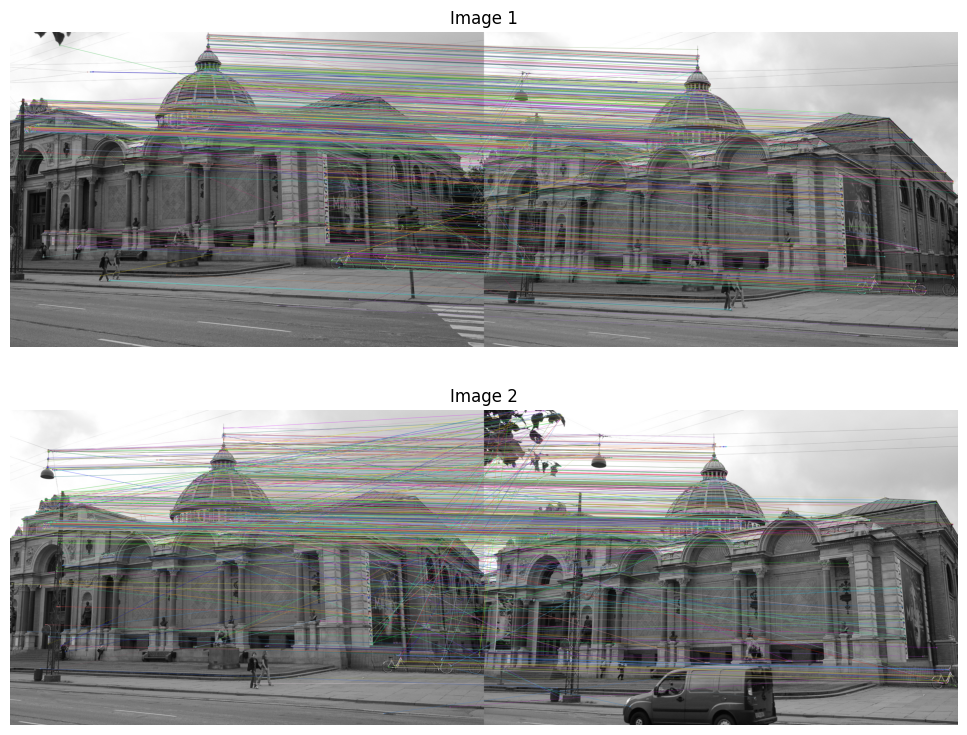

In [26]:
im_sift12 = cv2.drawMatches(im1_cv, kp1, im2_cv, kp2, matches12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)[:,:,::-1]
im_sift23 = cv2.drawMatches(im2_cv, kp2, im3_cv, kp3, matches23, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)[:,:,::-1]

fig = plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
plt.title("Image 1")
plt.axis("off")
plt.imshow(im_sift12)

plt.subplot(2, 1, 2)
plt.title("Image 2")
plt.axis("off")
plt.imshow(im_sift23)

plt.show()

#### Amount of matches?

In [27]:
print(f"Number of matches between im1 and im2: {matches12_np.shape}")
print(f"Number of matches between im2 and im3: {matches23_np.shape}\n")

Number of matches between im1 and im2: (958, 2)
Number of matches between im2 and im3: (860, 2)



## Ex. 11.2

Estimate the essential matrix between im0 and im1 with **RANSAC**. You can use the *OpenCV* function `cv2.findEssentialMat` to do this.


Decompose the essential matrix and find the correct relative pose (`R1`, `t1`). For this we can again
use an *OpenCV* function namely `cv2.recoverPose`.


The mask returned by `cv2.recoverPose` indicates which of the matches are inliers, that lie in front of both cameras. Remove the matches that are not inliers from `matches01`, so that only contains the inliers.


### Response

Finding the essential matrix

In [35]:
E_12, mask_12 = cv2.findEssentialMat(
    points1 = kp1_np[matches12_np[:, 0]],
    points2 = kp2_np[matches12_np[:, 1]],
    cameraMatrix=K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
    )

print(f"Essential matrix: \n{E_12}\n")
print(f"Mask: \n{mask_12.T}\n")

Essential matrix: 
[[ 0.00181012  0.26615472 -0.03553722]
 [-0.2731766   0.03357334 -0.64955741]
 [ 0.05431955  0.65294486  0.03050299]]

Mask: 
[[0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1
  1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0
  1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
  1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1
  1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
  0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
  1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
  0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
  1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1
  1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1
  0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0
  1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0

Recovering the pose using *CV2*

In [47]:
retval_12, R_12, t_12, mask_12_recovered = cv2.recoverPose(
    E = E_12,
    points1 = kp1_np[matches12_np[:, 0]],
    points2 = kp2_np[matches12_np[:, 1]],
    cameraMatrix = K
    )

num_points_to_show = 10

print(f"Rotation matrix: \n{R_12}\n")
print(f"Translation vector: \n{t_12}\n")
print(f"Recovered mask (first {num_points_to_show} points): \n{mask_12_recovered.T[0][:num_points_to_show]}\n")

mask_12_recov_normal = mask_12_recovered/ 255
print(f"Biggest number in mask after normalized: \n{mask_12_recov_normal.max()}\n")

mask_12_recov_bool = mask_12_recov_normal.astype(bool)
print(f"Boolean mask (first {num_points_to_show} points): \n{mask_12_recov_bool.T[0][:num_points_to_show]}\n")

Rotation matrix: 
[[ 0.99986031 -0.00870514 -0.0142681 ]
 [ 0.00937649  0.99881855  0.04768206]
 [ 0.01383616 -0.04780919  0.99876065]]

Translation vector: 
[[ 0.92508972]
 [-0.06815487]
 [-0.37358255]]

Recovered mask (first 10 points): 
[255 255 255 255   0 255 255 255   0 255]

Biggest number in mask after normalized: 
1.0

Boolean mask (first 10 points): 
[ True  True  True  True False  True  True  True False  True]



#### Removing the matches that aren't inliers
With regards to the recovered mask

In [55]:
print(f"Dimensionality of matches: {matches12_np.shape}\n")
print(f"Dimensionality of recovered mask: {mask_12_recov_bool.shape}\n")
inlier_matches12 = matches12_np[mask_12_recov_bool[:, 0], :]

print(f"masked matches: \n{inlier_matches12}\n")
print(f"Shape of masked matches: {inlier_matches12.shape}\n")

Dimensionality of matches: (958, 2)

Dimensionality of recovered mask: (958, 1)

masked matches: 
[[   0 1593]
 [   4  209]
 [   5  365]
 ...
 [1985 1806]
 [1986 1808]
 [1989 1431]]

Shape of masked matches: (857, 2)



## Ex. 11.3

Use `matches12` and `matches23` and find the subset of matches such that we can match features all the way from *image 0* to *image 2*. In other words, create three lists such that `points0[i]`, `points1[i]`, and `points2[i]` are the 2D locations of the same point in the corresponding images.


For this you can use:

`_, idx01, idx12 = np.intersect1d(matches01[:, 1], matches12[:, 0], return_indices=True)`

### Response

In [57]:
_, idx12, idx23 = np.intersect1d(matches12_np[:, 1], matches23_np[:, 0], return_indices=True)




## Ex. 11.4

For the points that have been tracked through all three images, use the 2D positions in *image 0* and *1* to triangulate the points in 3D (Q). Using the 2D positions in *image 2*, estimate the pose of *image 2* with **RANSAC**. Use `cv2.solvePnPRansac` to do this. As the lens distortion is already corrected, you can set `distCoeffs = np.zeros(5)`.


Visualize the 3D points that are also inliers for `solvePnPRansac`.

```
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(*Q[inliers.flatten()])
```

Also plot the position of the cameras. Recall that the position of the camera is not the translation.
How do you find the position?

